## Load Data

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

NUM_CLASSES = 10
INPUT_SIZE = 784

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Data Augmentation
Rotate

In [3]:
from scipy.ndimage import rotate

def rotate_image(image, max_angle):
    random_angle = np.random.uniform(low=-max_angle, high=max_angle)
    return rotate(image, random_angle, reshape=False)

x_train_rotated = np.empty_like(x_train)

for i in range(0, x_train.shape[0]):
    x_train_rotated[i] = rotate_image(x_train[i], 25)

Blure

In [4]:
from scipy.ndimage import gaussian_filter

def blur_image(image, sigma=1):
    return gaussian_filter(image, sigma=sigma)

x_train_blurred = np.empty_like(x_train)

for i in range(0, x_train.shape[0]):
    x_train_blurred[i] = blur_image(x_train[i], sigma=1)

## Data Visualization

8


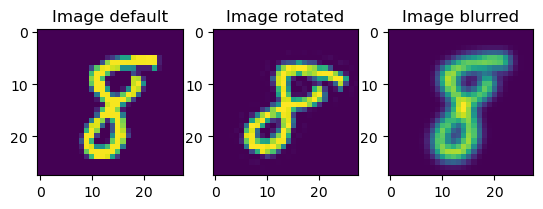

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

random_index = np.random.randint(0, len(x_train))

print(y_train[random_index])

fig, axes = plt.subplots(1, 3)

axes[0].imshow(x_train[random_index])
axes[0].set_title('Image default')

axes[1].imshow(x_train_rotated[random_index])
axes[1].set_title('Image rotated')

axes[2].imshow(x_train_blurred[random_index])
axes[2].set_title('Image blurred')

plt.show()

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

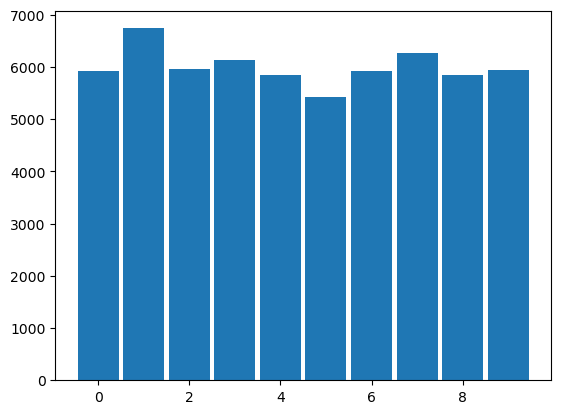

In [6]:
plt.hist(y_train, bins=range(11), align='left', rwidth=0.9)

## Normalization

In [7]:
def normalize(arrays):
    for array in arrays:
        array = array / 127.5 - 1
        yield array.reshape(array.shape[0], INPUT_SIZE)

x_train, x_test, x_train_rotated, x_train_blurred =\
    normalize([x_train, x_test, x_train_rotated, x_train_blurred])

In [8]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## TensorFlow Model

In [ ]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model_tf_1 = Sequential()
model_tf_1.add(Dense(
        units=128,
        activation='relu',
        kernel_initializer='he_normal'
))
model_tf_1.add(Dense(
        units=64,
        activation='relu',
        kernel_initializer='he_normal'
))
model_tf_1.add(Dense(
        units=NUM_CLASSES,
        activation='softmax',
        kernel_initializer='he_normal'
))

model_tf_1.compile(
        optimizer=Adam(learning_rate=0.0002),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
)

model_tf_1.fit(
        x=x_train,
        y=y_train,
        epochs=5,
        validation_data=(x_test, y_test),
        batch_size=16
)


## PyTorch Model

In [16]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class PyTorchModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(INPUT_SIZE, 64)
        # self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, NUM_CLASSES)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        # x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)  # No activation, CrossEntropyLoss will take care of it
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)


## CallBack class

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time
# import pylab as pl
from IPython import display

class CallBack:
    def __init__(self, model):
        self.model = model

        # Losses & metrics
        self.train_loss = 0
        self.train_losses = []
        self.val_losses = []
        self.train_accuracy = 0
        self.val_accuracy = 0
        self.precision = []
        self.recall = []
        self.f1_scores = []

        # Time
        self.time_point = time.time()
        
        # Counters
        self.batch_counter = 0
        self.epoch_counter = 0

        # Data size
        self.data_size = 0


    def batch_end(self, labels, outputs, loss):
        preds = torch.argmax(outputs, dim=1)
        self.train_accuracy += accuracy_score(labels.cpu(), preds.cpu())

        self.train_loss += loss
        self.batch_counter += 1


    def epoch_end(self):
        self.train_loss /= self.batch_counter
        self.train_accuracy /= self.batch_counter
        self.epoch_counter += 1


        self.batch_counter = 0
        self.train_accuracy = 0
        self.train_losses.append(self.train_loss)
        self.train_loss = 0

  
    def validation_end(self, labels, outputs, loss):
        # Update and print validation metrics
        self.val_losses.append(loss)
        
        # Convert outputs to class predictions if it's not done already
        preds = torch.argmax(outputs, dim=1)
        self.val_accuracy = accuracy_score(labels.cpu(), preds.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu())
        
        self.precision.append(precision)
        self.recall.append(recall)
        self.f1_scores.append(f1)


    def update_plot(self):
        plt.cla()

        fig, axes = plt.subplots(2, 1)
        fig.set_size_inches(6, 12)

        axes[0].plot(self.train_losses, label='Training loss')
        axes[0].plot(self.val_losses, label='Validation loss')
        axes[0].legend()
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')

        axes[1].bar(range(10), self.precision[-1], label='Precision', width=0.3, align='edge')
        axes[1].bar(range(10), self.recall[-1], label='Recall', width=-0.3, align='edge')
        axes[1].bar(range(10), self.f1_scores[-1], label='F1', width=0.3, align='center')
        axes[1].set_xlabel('Class')
        axes[1].set_ylabel('Metric')
        axes[1].legend()

        display.clear_output(wait=True)
        display.display(fig)
        plt.close(fig)

        print("Validation accuracy: ", self.val_accuracy)
        print("Time = ", time.time() - self.time_point)

In [12]:
from pynput.keyboard import Key, Listener

class Stopper:
    def __init__(self):
        self.stop = False
        self.listen()

    def on_release(self, key):
        if key == Key.esc:
            self.stop = True

    def listen(self):
        self.listener = Listener(
                on_release=self.on_release)
        self.listener.start()
    
    def __call__(self):
        return self.stop

In [13]:
def train(model, train_loader, optimizer, loss_func, epochs, val_x, val_y):
    callback = CallBack(model)
    stopper = Stopper()

    for _ in range(epochs):
        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad() # Clear the gradients
            outputs = model(inputs) # Forward pass
            loss = loss_func(outputs, labels) # Calculate the loss
            loss.backward() # Calculate the gradients (backpropagation)
            optimizer.step() # Update the weights

            callback.batch_end(labels, outputs, loss.item())

            if stopper():
                break
        
        if stopper():
            break

        callback.epoch_end()

        # Validation phase
        with torch.no_grad():  # Inference without gradient calculations
            model.eval()  # Set the model to evaluation mode
            outputs = model(val_x)
            val_loss = loss_func(outputs, val_y)

            callback.validation_end(val_y, outputs, val_loss.item())
        
        callback.update_plot()
    
    # plt.gcf().clear()
    plt.cla()
    plt.clf()
    plt.close(plt.gcf())


## Learning

In [14]:
learning_rate = 0.00003
batch = 64
epochs = 20

x_test_torch = torch.from_numpy(x_test).float()
y_test_torch = torch.from_numpy(y_test).long()


def create_datasets(x, y):
    train_dataset = TensorDataset(torch.Tensor(x), torch.Tensor(y).long())
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)
    return train_loader


Basic

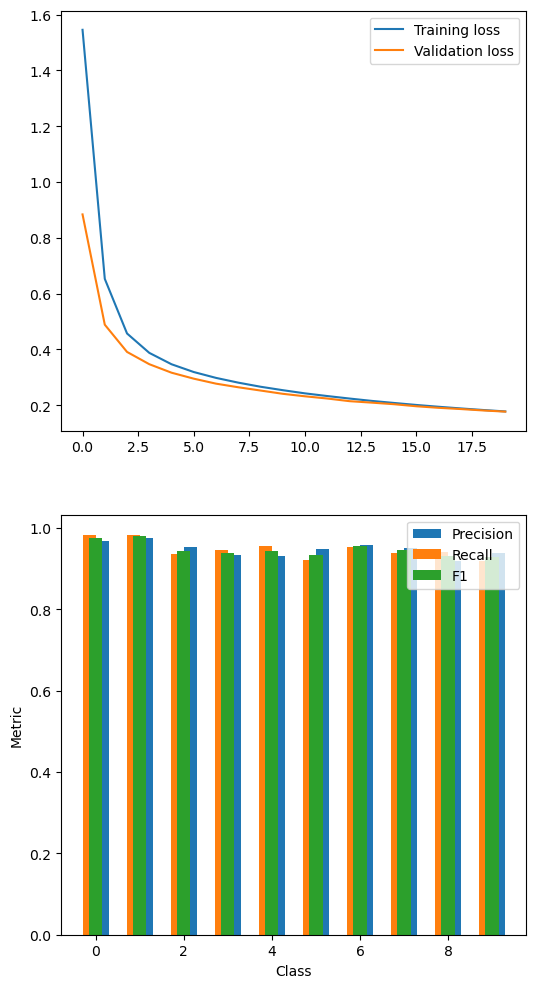

Validation accuracy:  0.9478
Time =  33.51907157897949


In [17]:
model = PyTorchModel_1()
model.apply(init_weights)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = create_datasets(x_train, y_train)

train(model, train_loader, optimizer, loss_func, epochs, x_test_torch, y_test_torch)

Rotate + Basic

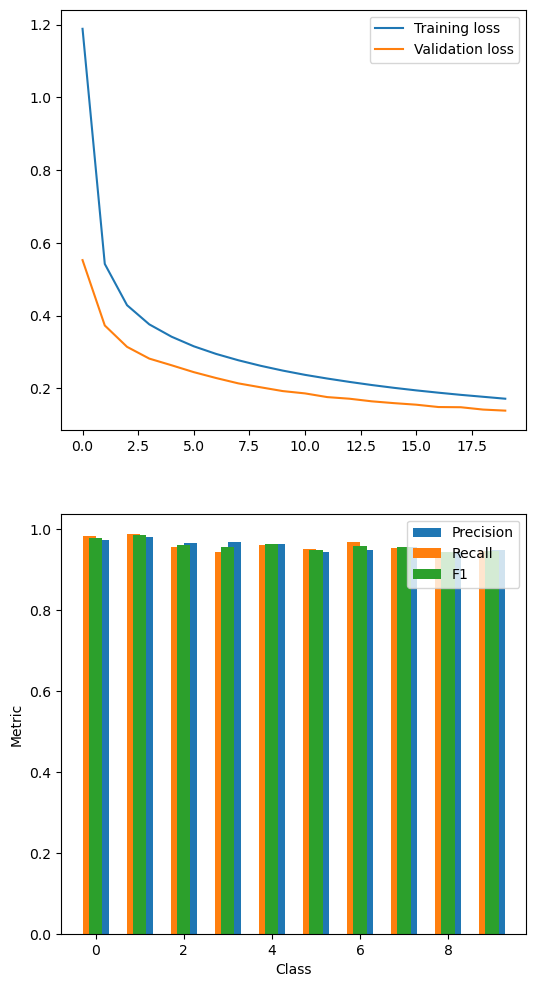

Validation accuracy:  0.9586
Time =  57.15842819213867


In [18]:
model = PyTorchModel_1()
model.apply(init_weights)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = create_datasets(np.concatenate((x_train, x_train_rotated)), np.concatenate((y_train, y_train)))

train(model, train_loader, optimizer, loss_func, epochs, x_test_torch, y_test_torch)

Blur + Basic

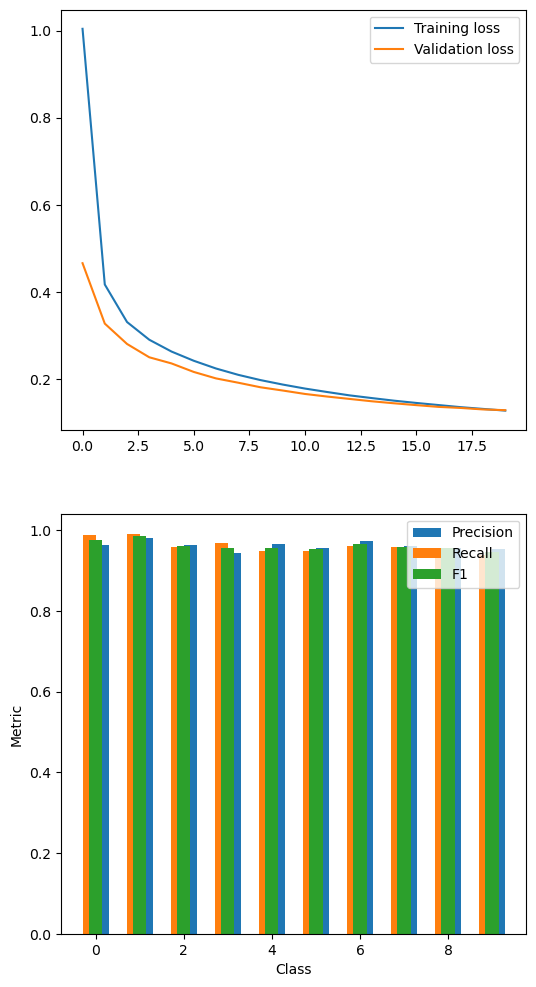

Validation accuracy:  0.962
Time =  59.17660355567932


In [19]:
model = PyTorchModel_1()
model.apply(init_weights)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = create_datasets(np.concatenate((x_train, x_train_blurred)), np.concatenate((y_train, y_train)))

train(model, train_loader, optimizer, loss_func, epochs, x_test_torch, y_test_torch)

Blur + Rotate + Basic

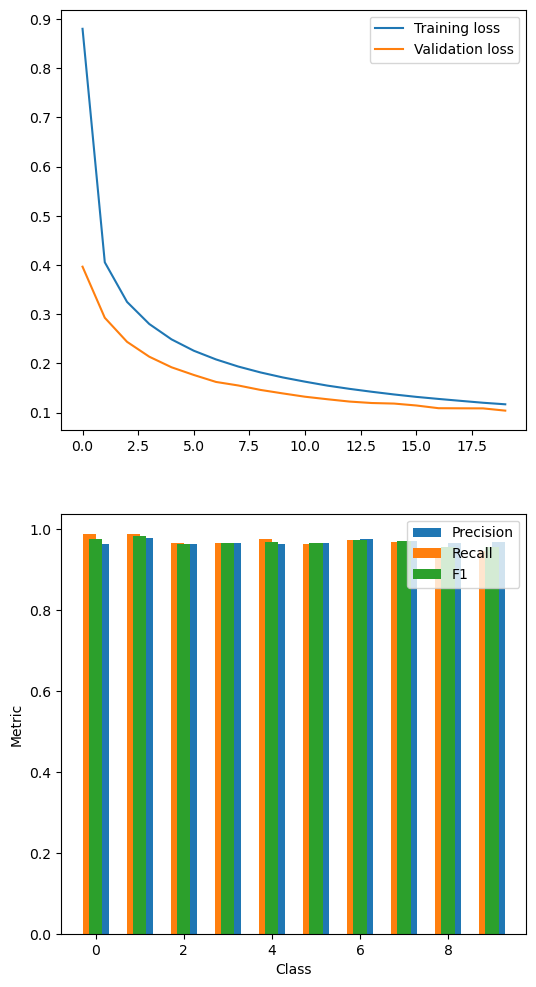

Validation accuracy:  0.968
Time =  122.43336296081543


In [21]:
model = PyTorchModel_1()
model.apply(init_weights)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loader = create_datasets(np.concatenate((x_train, x_train_blurred, x_train_rotated)),
                               np.concatenate((y_train, y_train, y_train)))

train(model, train_loader, optimizer, loss_func, epochs, x_test_torch, y_test_torch)

Blur + Rotate

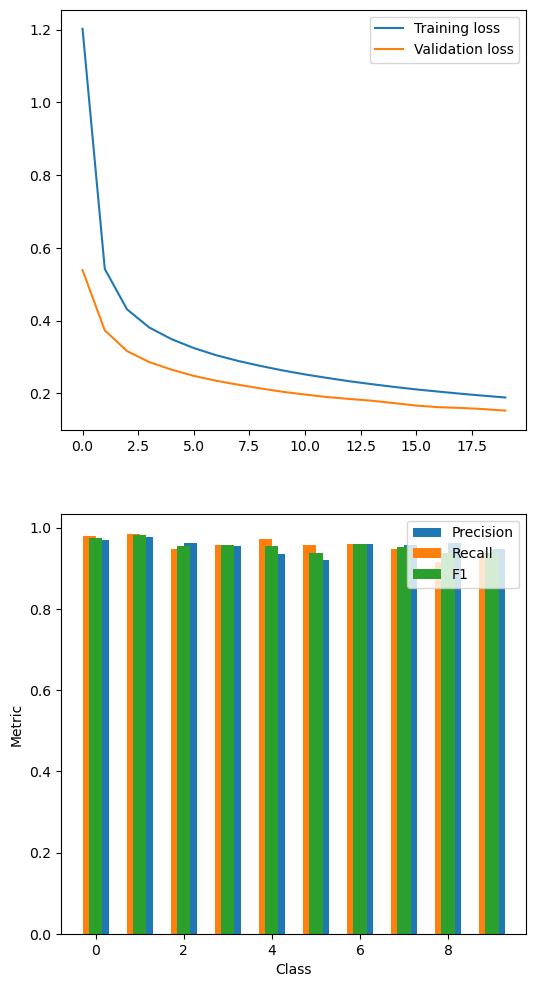

Validation accuracy:  0.9554
Time =  73.31550526618958


In [22]:
model = PyTorchModel_1()
model.apply(init_weights)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = create_datasets(np.concatenate((x_train_rotated, x_train_blurred)),
                               np.concatenate((y_train, y_train)))

train(model, train_loader, optimizer, loss_func, epochs, x_test_torch, y_test_torch)